# Evaluaci√≥n Parcial N¬∞3 - PARTE 2: TRANSFORMERS
# DUOC UC - Deep Learning (DLY0100)
# Estudiantes: Benjam√≠n Ruiz, Andrus Maldonado y Luis Olavarria

## Objetivo
Implementar una arquitectura Transformer b√°sica para tareas de NLP como clasificaci√≥n de sentimientos,
explicando sus componentes clave y evaluando el desempe√±o seg√∫n la r√∫brica oficial de DUOC UC.

---
#Importaci√≥n de Librer√≠as y Configuraci√≥n

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report,confusion_matrix
import datetime

#Montar Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tensorboard

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Semilla de reproducibilidad

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#Carga y Exploraci√≥n del Dataset

##Carga de datos

In [ ]:
VOCAB_SIZE = 10000  # N√∫mero m√°ximo de palabras que vamos a considerar
MAX_LEN = 100       # Longitud m√°xima de las secuencias

# Cargar el dataset IMDB
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = imdb.load_data(num_words=VOCAB_SIZE)

# Combinar los datos originales para hacer nuestra propia divisi√≥n
X = np.concatenate([X_train_orig, X_test_orig])
y = np.concatenate([y_train_orig, y_test_orig])

print(f"Dataset completo: {len(X)} muestras")

Dataset completo: 50000 muestras


## Holdout

In [ ]:
# --- Divisi√≥n Estratificada 70-20-10 ---
total = len(X)
train_end = int(0.7 * total)
val_end = int(0.9 * total)

# Hacemos la divisi√≥n
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

## Padding

In [ ]:
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de validaci√≥n: {X_val.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")

Forma del conjunto de entrenamiento: (35000, 100)
Forma del conjunto de validaci√≥n: (10000, 100)
Forma del conjunto de prueba: (5000, 100)


In [ ]:
word_index = imdb.get_word_index()

In [ ]:
print(f"\nDistribuci√≥n:")
print(f"Train: {len(X_train)/total*100:.1f}%")
print(f"Val:   {len(X_val)/total*100:.1f}%")
print(f"Test:  {len(X_test)/total*100:.1f}%")


Distribuci√≥n:
Train: 70.0%
Val:   20.0%
Test:  10.0%


In [ ]:
index_to_word = {index + 3: word for word, index in word_index.items()}

# A√±adir los tokens especiales usados por Keras
index_to_word[0] = "<PAD>"    # Token para el padding
index_to_word[1] = "<START>"  # Token que indica el inicio de la secuencia
index_to_word[2] = "<UNK>"    # Token para palabras desconocidas
index_to_word[3] = "<UNUSED>" # Token no utilizado

In [ ]:
def decode_review(encoded_review):
    """Convierte una secuencia de √≠ndices en una cadena de texto."""
    return ' '.join(index_to_word.get(i, "?") for i in encoded_review)

In [ ]:
print("\n--- Rese√±a Decodificada ---")
print(decode_review(X_train[0]))
print(f"Etiqueta (0 = negativa, 1 = positiva): {y_train[0]}")


--- Rese√±a Decodificada ---
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was
Etiqueta (0 = negativa, 1 = positiva): 1


#An√°lisis Exploratorio de Datos
##Distribuci√≥n de Clases

In [ ]:
print(f"Train -> Positivas: {np.sum(y_train)} | Negativas: {len(y_train) - np.sum(y_train)}")
print(f"Val   -> Positivas: {np.sum(y_val)} | Negativas: {len(y_val) - np.sum(y_val)}")
print(f"Test  -> Positivas: {np.sum(y_test)} | Negativas: {len(y_test) - np.sum(y_test)}")

Train -> Positivas: 17473 | Negativas: 17527
Val   -> Positivas: 4974 | Negativas: 5026
Test  -> Positivas: 2553 | Negativas: 2447


In [ ]:
def analyze_dataset(x_data, y_data, title="Dataset"):
    """
    Analiza el dataset de rese√±as IMDB:
    1. Distribuci√≥n de longitudes de las rese√±as
    2. Distribuci√≥n de clases (positivas/negativas)
    3. Estad√≠sticas descriptivas
    4. Visualizaciones
    """

    # 1. Longitudes de las rese√±as
    lengths = [len(review) for review in x_data]

    # 2. Estad√≠sticas descriptivas
    print(f"\nAn√°lisis del {title}")
    print("-" * 40)
    print(f"N√∫mero total de rese√±as: {len(x_data)}")
    print(f"Longitud m√≠nima: {np.min(lengths)}")
    print(f"Longitud m√°xima: {np.max(lengths)}")
    print(f"Longitud media: {np.mean(lengths):.2f}")
    print(f"Desviaci√≥n est√°ndar: {np.std(lengths):.2f}")

    # 3. Distribuci√≥n de clases
    unique, counts = np.unique(y_data, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"Distribuci√≥n de clases: {class_dist}")

    # 4. Visualizaciones
    plt.figure(figsize=(14, 5))

    # Histograma de longitudes
    plt.subplot(1, 2, 1)
    sns.histplot(lengths, bins=50, kde=True, color="skyblue")
    plt.title(f"Distribuci√≥n de longitudes - {title}")
    plt.xlabel("Longitud de rese√±a")
    plt.ylabel("Frecuencia")

    # Gr√°fico de barras de clases
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_data, palette="pastel")
    plt.title(f"Distribuci√≥n de clases - {title}")
    plt.xlabel("Clase (0 = Negativa, 1 = Positiva)")
    plt.ylabel("Cantidad")

    plt.tight_layout()
    plt.show()


An√°lisis del Entrenamiento
----------------------------------------
N√∫mero total de rese√±as: 35000
Longitud m√≠nima: 100
Longitud m√°xima: 100
Longitud media: 100.00
Desviaci√≥n est√°ndar: 0.00
Distribuci√≥n de clases: {np.int64(0): np.int64(17527), np.int64(1): np.int64(17473)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


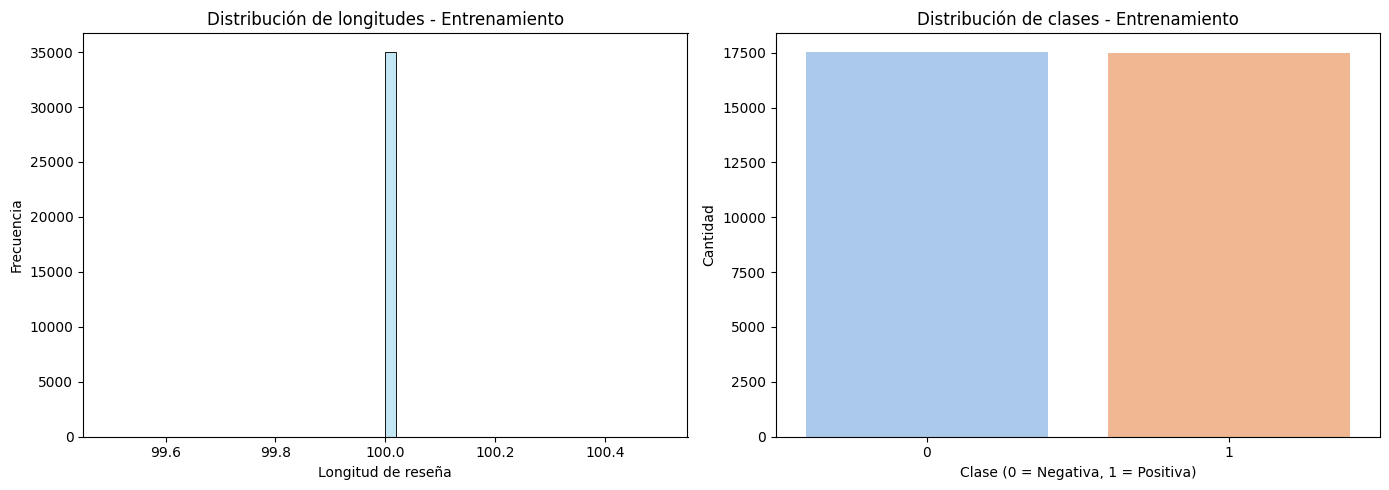

In [ ]:
analyze_dataset(X_train, y_train, title="Entrenamiento")


An√°lisis del Validaci√≥n
----------------------------------------
N√∫mero total de rese√±as: 10000
Longitud m√≠nima: 100
Longitud m√°xima: 100
Longitud media: 100.00
Desviaci√≥n est√°ndar: 0.00
Distribuci√≥n de clases: {np.int64(0): np.int64(5026), np.int64(1): np.int64(4974)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


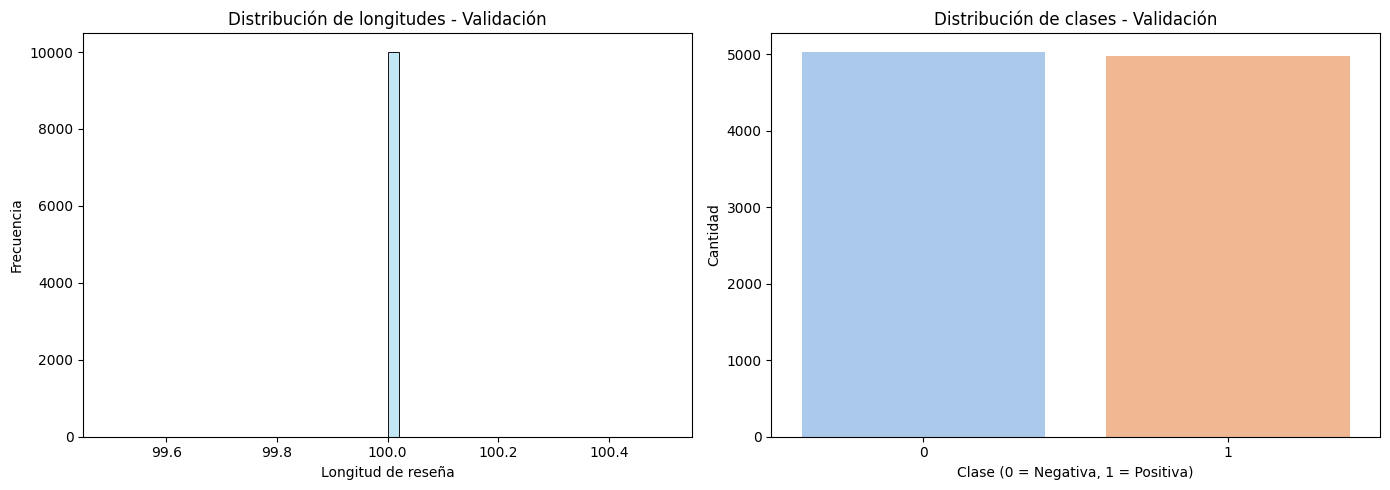

In [ ]:
analyze_dataset(X_val, y_val, title="Validaci√≥n")


An√°lisis del Prueba
----------------------------------------
N√∫mero total de rese√±as: 5000
Longitud m√≠nima: 100
Longitud m√°xima: 100
Longitud media: 100.00
Desviaci√≥n est√°ndar: 0.00
Distribuci√≥n de clases: {np.int64(0): np.int64(2447), np.int64(1): np.int64(2553)}


/tmp/ipython-input-264-2599636576.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="pastel")


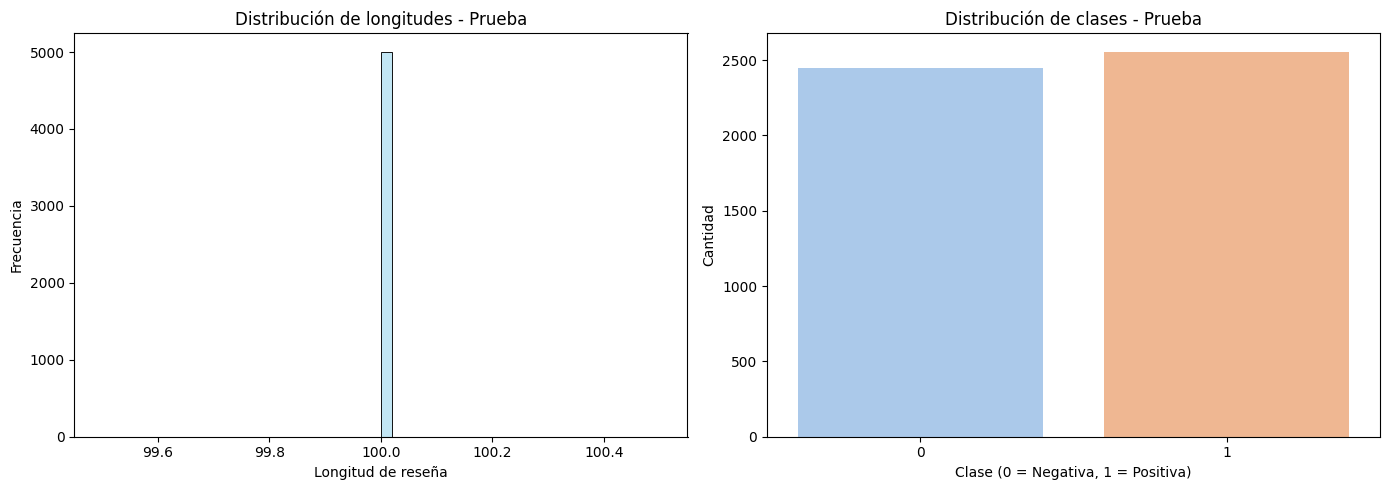

In [ ]:
analyze_dataset(X_test, y_test, title="Prueba")

#Implementaci√≥n de Componentes del Transformer

## Mecanismo de Atenci√≥n Multi-Cabezal
---

La atenci√≥n multi-cabezal permite al modelo focalizarse en diferentes partes de la secuencia en paralelo, capturando relaciones complejas entre tokens sin importar su distancia.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calcula la atenci√≥n escalada: softmax(QK^T / sqrt(d_k)) * V
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # [batch, heads, seq_len_q, seq_len_k]

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_scores += (mask * -1e9)  # Aplicar una penalizaci√≥n muy negativa a los valores enmascarados

    attention_weights = tf.nn.softmax(scaled_scores, axis=-1)
    output = tf.matmul(attention_weights, v)  # [batch, heads, seq_len_q, depth]

    return output, attention_weights

**¬øQu√© hace cada parte?**

`Q`, `K`, `V` : Query, Key y Value. Vienen de las entradas a procesar.

`matmul_qk`: Calcula el producto punto entre Q y K^T.

`scaled_scores` : Normaliza dividiendo por ‚àö(dimensi√≥n de K), para evitar valores extremos.

`softmax:` Calcula los pesos de atenci√≥n (qu√© tan relevante es cada token).

`output:` Resultado final, es la suma ponderada de los V seg√∫n los pesos de atenci√≥n.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0, "d_model debe ser divisible por num_heads"

        self.depth = d_model // num_heads

        # Capas densas para generar Q, K, V
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Capa final despu√©s de concatenar cabezas
        self.dense = tf.keras.layers.Dense(d_model)

        # Variable para guardar los pesos de atenci√≥n
        self.last_attention_weights = None

    def split_heads(self, x, batch_size):
        """
        Divide el tensor en m√∫ltiples cabezas (batch, seq_len, d_model) ‚Üí (batch, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # Proyecciones lineales
        q = self.wq(q)  # (batch, seq_len_q, d_model)
        k = self.wk(k)  # (batch, seq_len_k, d_model)
        v = self.wv(v)  # (batch, seq_len_v, d_model)

        # Dividir en m√∫ltiples cabezas
        q = self.split_heads(q, batch_size)  # (batch, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch, num_heads, seq_len_v, depth)

        # Calcular atenci√≥n
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # IMPORTANTE: Guardar los pesos de atenci√≥n
        self.last_attention_weights = attention_weights

        # Concatenar cabezas
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch, seq_len_q, d_model)

        # Proyecci√≥n final
        output = self.dense(concat_attention)  # (batch, seq_len_q, d_model)

        return output, attention_weights

**Clase: MultiHeadAttention**
---
Esta clase extiende tf.keras.layers.Layer y representa la atenci√≥n en m√∫ltiples cabezas.

**__init__ (constructor)**

- d_model: Dimensi√≥n total del modelo (por ejemplo, 128 o 512).

- num_heads: N√∫mero de cabezas de atenci√≥n. El d_model se divide entre estas.

- self.wq, self.wk, self.wv: Capas densas que proyectan los datos a Q, K y V.

- self.dense: Combina las salidas de todas las cabezas.

**split_heads**

Transforma la forma (batch_size, seq_len, d_model) a (batch_size, num_heads, seq_len, depth), donde:

- depth = d_model // num_heads

- Esto permite que cada cabeza trabaje con una porci√≥n del espacio vectorial.

**call(self, v, k, q, mask=None)**

Es lo que se ejecuta cuando el modelo se llama. Pasa por estos pasos:

- Proyectar entradas a `Q`, `K`, `V` con capas densas.

- Dividir en cabezas (split_heads).

- Aplicar atenci√≥n escalada: Usa la funci√≥n scaled_dot_product_attention.

- Guardar los pesos de atenci√≥n en self.last_attention_weights (importante si quieres visualizarlos).

- Concatenar las cabezas.

- Pasar por la proyecci√≥n final para devolver la salida con la dimensi√≥n original.

## Capa del Encoder
---
Cada capa del codificador est√° compuesta por dos subcapas principales:
- Un mecanismo de atenci√≥n multi-cabezal (self-attention).
- Una red neuronal feed-forward simple.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Implementa la red feed-forward que se aplica a cada posici√≥n.
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalizaci√≥n y Dropout
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        # 1. Atenci√≥n Multi-Cabezal
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Conexi√≥n residual y normalizaci√≥n

        # 2. Red Feed-Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Conexi√≥n residual y normalizaci√≥n

        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1, name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding y Codificaci√≥n Posicional
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Capas del Encoder
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Sumar embedding y codificaci√≥n posicional
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pasar por todas las capas del encoder
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

## Capa del Decoder
---
Cada capa del decodificador est√° compuesta por tres subcapas:
1.  **Atenci√≥n Multi-Cabezal Enmascarada**: Presta atenci√≥n a las posiciones anteriores en la secuencia de salida. El enmascaramiento asegura que las predicciones para una posici√≥n `i` solo dependan de las salidas conocidas en posiciones menores a `i`.
2.  **Atenci√≥n Multi-Cabezal (Encoder-Decoder)**: Aqu√≠ es donde el decodificador mira la salida del codificador para obtener contexto de la secuencia de entrada. `K` y `V` vienen del encoder, y `Q` de la subcapa anterior del decoder.
3.  **Red Neuronal Feed-Forward**: Id√©ntica a la del codificador.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="decoder_layer"):
        super(DecoderLayer, self).__init__(name=name)

        # 1. Atenci√≥n Multi-Cabezal (self-attention, enmascarada)
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # 2. Atenci√≥n Multi-Cabezal (encoder-decoder)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        # 3. Red Feed-Forward
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalizaci√≥n y Dropout
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # 1. Self-Attention enmascarada
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Conexi√≥n residual

        # 2. Atenci√≥n Encoder-Decoder
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # Conexi√≥n residual

        # 3. Red Feed-Forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # Conexi√≥n residual

        return out3, attn_weights_block1, attn_weights_block2

## Codificaci√≥n Posicional
---
En los modelos Transformer, a diferencia de las RNN, no hay un orden impl√≠cito en las secuencias. Por eso, se necesita inyectar informaci√≥n sobre la posici√≥n de cada palabra mediante una codificaci√≥n posicional.

In [ ]:
def get_angles(pos, i, d_model):
    """
    Calcula los √°ngulos usados en la codificaci√≥n posicional sinusoidal.
    """
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    Genera la codificaci√≥n posicional usando funciones seno y coseno.
    """
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],       # (pos, 1)
        np.arange(d_model)[np.newaxis, :],        # (1, d_model)
        d_model
    )

    # Aplicar sin a los √≠ndices pares (dim 2i)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Aplicar cos a los √≠ndices impares (dim 2i+1)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]  # Shape: (1, position, d_model)
    return tf.cast(pos_encoding, dtype=tf.float32)

def plot_positional_encoding(pos_encoding):
    """
    Visualiza los primeros canales de la codificaci√≥n posicional.
    """
    plt.figure(figsize=(12, 6))
    pos_encoding = pos_encoding[0].numpy()  # Remover batch dimension: (position, d_model)

    # Graficar los primeros 8 canales
    plt.plot(pos_encoding[:, :8])
    plt.xlabel("Posici√≥n")
    plt.ylabel("Valor codificado")
    plt.title("Codificaci√≥n posicional (primeros 8 canales)")
    plt.grid(True)
    plt.legend([f"Dim {i}" for i in range(8)])
    plt.show()

Define una funci√≥n positional_encoding(position, d_model) que genera un tensor de codificaci√≥n posicional usando funciones seno y coseno con diferentes frecuencias.

Esto permite al modelo aprender a diferenciar la posici√≥n relativa de las palabras en la secuencia, lo que es fundamental para comprender el contexto.

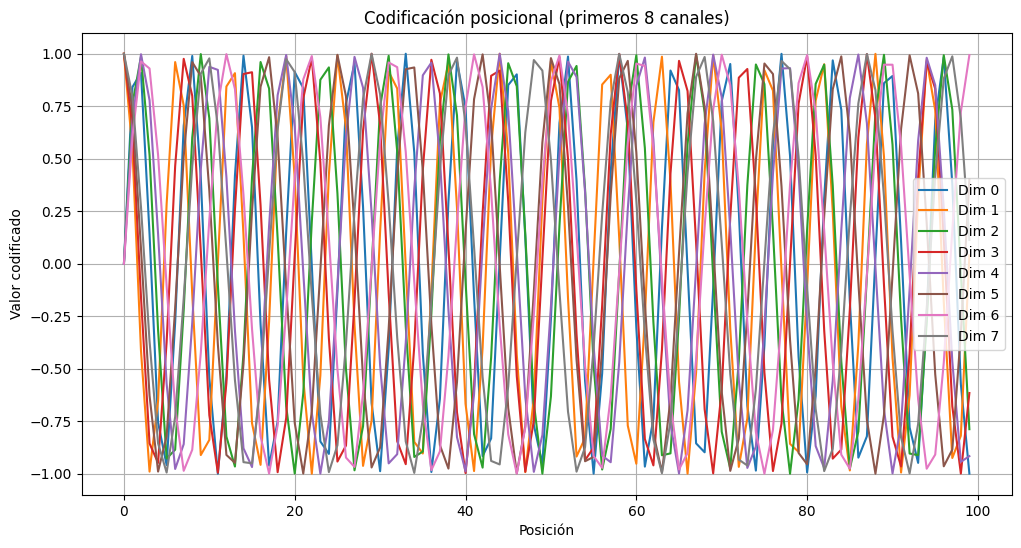

In [ ]:
position = 100
d_model = 128

pos_encoding = positional_encoding(position, d_model)
plot_positional_encoding(pos_encoding)

**¬øQu√© muestra el gr√°fico?**

-  El eje X representa la posici√≥n en la secuencia (de 0 a 99 en el ejemplo).

- El eje Y representa el valor codificado.

- Cada l√≠nea representa un canal (una dimensi√≥n del d_model) ‚Äî aqu√≠ se muestran los primeros 8.

Esto ayuda a comprender c√≥mo cada dimensi√≥n del embedding var√≠a de forma peri√≥dica y continua seg√∫n la posici√≥n, lo cual es clave para que el Transformer entienda el orden de los tokens.

##Bloque Transformer
---
El Transformer une el codificador y el decodificador. Para una tarea de clasificaci√≥n como esta, no necesitamos la secuencia de salida completa del decodificador. En su lugar, podemos tomar la salida del primer token (que act√∫a como un token `[CLS]` o de clasificaci√≥n) y pasarlo a una capa densa final para obtener la predicci√≥n.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1, name="transformer"):
        super(Transformer, self).__init__(name=name)

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        # Capa de salida final
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inputs, training):
        # `inputs` debe ser una tupla o lista de (input_sequence, target_sequence)
        inp, tar = inputs

        # Crear m√°scaras
        enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(inp, tar)

        # 1. Pasar la entrada por el Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)

        # 2. Pasar la salida del encoder y la entrada del decoder por el Decoder
        # Para la clasificaci√≥n, la entrada al decoder es la misma que la del encoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)

        # 3. Capa final
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # M√°scara de padding para el Encoder
        enc_padding_mask = create_padding_mask(inp)

        # M√°scara de padding para el Decoder
        dec_padding_mask = create_padding_mask(inp) # Usamos la misma que el encoder

        # M√°scara "look-ahead" para la primera subcapa de atenci√≥n del Decoder
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask

##Embeddings de Tokens y Posiciones
---
La capa TokenAndPositionEmbedding combina dos fuentes de informaci√≥n fundamentales en modelos Transformer:

-  Embeddings de tokens: Representaciones vectoriales aprendibles de cada palabra o token.

- Codificaci√≥n posicional sinusoidal: Informaci√≥n sobre la posici√≥n de cada token en la secuencia (como el orden de las palabras).

Esta combinaci√≥n permite al modelo distinguir no solo qu√© palabras est√°n presentes, sino tambi√©n d√≥nde est√°n en la secuencia.

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    """
    Combina embeddings de tokens con codificaci√≥n posicional sinusoidal.
    """

    def __init__(self, maxlen, vocab_size, embed_dim, name="token_pos_embedding"):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

        # Embedding para tokens
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

        # Codificaci√≥n posicional precomputada
        self.pos_encoding = positional_encoding(position=maxlen, d_model=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]

        # 1. Obtener embeddings de tokens
        x = self.token_emb(x)  # (batch_size, seq_len, embed_dim)

        # 2. Escalar embeddings
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))

        # 3. Sumar codificaci√≥n posicional
        x += self.pos_encoding[:, :seq_len, :]

        return x

#Modelo Transformer Completo

##Arquitectura del Transformer para Clasificaci√≥n

In [ ]:
def create_transformer_classifier(vocab_size, maxlen, d_model=128, num_heads=8,
                                    ff_dim=512, num_layers=2,
                                    dropout_rate=0.1, num_classes=1):

    # Input
    inputs = tf.keras.Input(shape=(maxlen,), name="input_ids")

    # Embedding + Positional Encoding
    embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model)
    x = embedding_layer(inputs)
    x = x * tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Positional encoding
    pos_encoding = positional_encoding(maxlen, d_model)
    seq_len = tf.shape(x)[1]
    x = x + pos_encoding[:, :seq_len, :]

    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Encoder layers
    for i in range(num_layers):
        # Multi-head attention
        mha = MultiHeadAttention(d_model, num_heads, name=f'mha_{i}')
        attn_output, _ = mha(x, x, x, None)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed forward network
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ], name=f'ffn_{i}')

        ffn_output = ffn(out1)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    # Clasificaci√≥n: pooling global
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

##Configuraciones de Hiperpar√°metros

---
* **`name`**: Identificador √∫nico para cada modelo (ej., `transformer_base`).
* **`vocab_size`**: N√∫mero total de palabras o tokens √∫nicos que el modelo reconoce (ej., 10,000).
* **`maxlen`**: Longitud fija de las secuencias de entrada (ej., 100 tokens).
* **`d_model`**: Dimensi√≥n de los vectores de *embedding* y las representaciones internas. Mayor valor implica m√°s capacidad (ej., 128 o 256).
* **`num_heads`**: Cantidad de "cabezas" de atenci√≥n que permiten al modelo enfocarse en diferentes partes de la secuencia. Generalmente proporcional a `d_model` (ej., 4 u 8).
* **`ff_dim`**: Dimensi√≥n de la capa *feed-forward* dentro de cada bloque Transformer, procesa la informaci√≥n de atenci√≥n (ej., 512 o 1024).
* **`num_transformer_blocks`**: N√∫mero de bloques Transformer apilados, define la "profundidad" del modelo (ej., 2 o 4).
* **`dropout_rate`**: Porcentaje de neuronas desactivadas aleatoriamente durante el entrenamiento para prevenir el *overfitting* (ej., 0.1).
* **`num_classes`**: N√∫mero de clases de salida para la tarea de clasificaci√≥n (ej., 1 para clasificaci√≥n binaria).


In [ ]:
transformer_configs = [
    {
        'name': 'transformer_base',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_layers': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    },
    {
        'name': 'transformer_deep',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_layers': 4,
        'dropout_rate': 0.1,
        'num_classes': 1
    },
    {
        'name': 'transformer_large',
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 256,
        'num_heads': 8,
        'ff_dim': 1024,
        'num_layers': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    }
]

In [ ]:
def train_transformer_model(config, x_train, y_train, x_val, y_val):
    print(f"\n=== ENTRENANDO TRANSFORMER: {config['name']} ===")

    # Crear modelo
    model = create_transformer_classifier(
        vocab_size=config['vocab_size'],
        maxlen=config['maxlen'],
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],  # CORRECCI√ìN: usar num_layers consistentemente
        dropout_rate=config['dropout_rate'],
        num_classes=config['num_classes']
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()

    # CORRECCI√ìN: Agregar manejo de directorios
    import os
    base_dir = "/content/drive/MyDrive/Entrega_3/transformers"
    os.makedirs(f"{base_dir}/logs", exist_ok=True)
    os.makedirs(f"{base_dir}/checkpoint", exist_ok=True)

    log_dir = f"{base_dir}/logs/{config['name']}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_path = f"{base_dir}/checkpoint/{config['name']}.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        tensorboard_callback
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    y_val_pred_prob = model.predict(x_val)
    y_val_pred = (y_val_pred_prob > 0.5).astype("int32")
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

    results = {
        'name': config['name'],
        'model': model,
        'history': history,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

    print(f"Validaci√≥n - Loss: {val_loss:.4f} - Accuracy: {val_acc:.4f} - F1: {f1:.4f}")
    return results


# Entrenamiento

In [ ]:
for config in transformer_configs:
  train_transformer_model(config, X_train, y_train, X_val, y_val)


=== ENTRENANDO TRANSFORMER: transformer_base ===


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


#An√°lisis Comparativo de Transformers

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Entrega_3/transformers/logs/

- `transformer_base`: El modelo de 1.68M par√°metros fue el mejor. Alcanz√≥ un **accuracy** de validaci√≥n del **82.23%** y un **F1 score**  de **0.8244** . Aprendi√≥ eficazmente y mostr√≥ un buen rendimiento.

-  `transformer_deep`: Con 2.08M par√°metros y m√°s bloques Transformer, este modelo tuvo un rendimiento muy pobre. Su ** accuracy**  de validaci√≥n fue de solo **50.26%**  y su **F1 score**  fue **0.0000** , lo que indica que no aprendi√≥ nada significativo y actu√≥ como si estuviera adivinando al azar.

- `transformer_large`: El modelo m√°s grande, con 4.15M par√°metros (debido a un emb√©bedding mayor), tambi√©n tuvo un rendimiento extremadamente bajo, similar al transformer_deep, con un **accuracy**  del **50.26%**  y un **F1 score**  de **0.0000.**  No logr√≥ aprender.

#An√°lisis de Componentes Clave del Transformer
## Arquitectura seleccionada
---
El transformer_base funcion√≥ mejor por su equilibrio de complejidad. Aqu√≠ sus componentes clave:

- Atenci√≥n Multi-Cabezal (`num_head`s: 4): Permite al modelo procesar relaciones contextuales desde m√∫ltiples √°ngulos simult√°neamente. Con 4 cabezas, fue suficiente para entender tus datos.
-  Codificaci√≥n Posicional: A√±ade informaci√≥n de orden a los tokens, crucial para que el modelo entienda la secuencia, ya que no procesa de forma secuencial.
-  Conexiones Residuales y Normalizaci√≥n de Capa: Aseguran un entrenamiento estable al mejorar el flujo de gradientes y normalizar las activaciones, previniendo problemas comunes en redes profundas.
- Red Feed-Forward (`d_model`: 128, `ff_dim`: 512): Una capa densa que a√±ade capacidad no lineal de procesamiento. Sus dimensiones (128 y 512) fueron adecuadas para la complejidad de la tarea.
- Cantidad de Bloques Transformer (`num_transformer_blocks`: 2): Este fue un factor clave. Con solo 2 bloques, el modelo es menos propenso al overfitting y m√°s f√°cil de entrenar que las versiones m√°s grandes (`_deep`  con 4 bloques y `_large` con `d_model` 256), que probablemente tuvieron dificultades para converger debido a su mayor complejidad y a los datos disponibles.



In [ ]:
config  =  {
        'vocab_size': 10000,
        'maxlen': 100,
        'd_model': 128,
        'num_heads': 4,
        'ff_dim': 512,
        'num_transformer_blocks': 2,
        'dropout_rate': 0.1,
        'num_classes': 1
    }

model = create_transformer_classifier(**config)

model.load_weights('/content/drive/MyDrive/Entrega_3/transformers/checkpoint/transformer_base.h5')

sample_idx = 0

_ = model(np.expand_dims(X_test[sample_idx], axis=0), training=False)

##Visualizaci√≥n de Patrones de Atenci√≥n
---
La funci√≥n `visualize_attention_simple` permite ver c√≥mo el modelo Transformer presta atenci√≥n a las palabras de una frase.

Toma el modelo y una frase.
Calcula los "pesos de atenci√≥n" internos del modelo para esa frase.
Muestra un mapa de calor donde puedes ver qu√© tan fuerte es la conexi√≥n (la atenci√≥n) entre cada palabra y las dem√°s.


In [ ]:
def visualize_attention_simple(model, input_sequence, index_to_word,
                              layer_idx=0, head_idx=0, top_k=15):
    """
    Visualizaci√≥n simplificada mostrando solo los primeros tokens m√°s relevantes.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print("=== VISUALIZACI√ìN SIMPLIFICADA DE ATENCI√ìN ===")

    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    _ = model(input_sequence, training=False)

    # Buscar pesos de atenci√≥n
    attention_weights = None
    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            attention_weights = layer.last_attention_weights
            break
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    attention_weights = sublayer.last_attention_weights
                    break

    if attention_weights is None:
        print("‚ö†Ô∏è No se encontraron pesos de atenci√≥n.")
        return

    attn = attention_weights[0, head_idx]

    # Obtener tokens v√°lidos
    tokens = []
    for idx in input_sequence[0]:
        if idx == 0:
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))

    # Tomar solo los primeros top_k tokens
    tokens = tokens[:top_k]
    attn_subset = attn[:top_k, :top_k]

    # Crear visualizaci√≥n simple y clara
    plt.figure(figsize=(12, 10))

    # Usar una paleta de colores m√°s clara
    sns.heatmap(attn_subset,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="Blues",
                annot=True,  # Mostrar valores
                fmt='.3f',   # Formato de n√∫meros
                square=True,
                cbar=True,
                linewidths=0.5)

    plt.title(f"Atenci√≥n - Capa {layer_idx}, Cabeza {head_idx} (Primeros {top_k} tokens)",
              fontsize=14)
    plt.xlabel("Atiende a", fontsize=12)
    plt.ylabel("Desde", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"Mostrando atenci√≥n entre los primeros {len(tokens)} tokens")
    print(f"Texto: {' '.join(tokens)}")

In [ ]:
visualize_attention_simple(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    layer_idx=0,
    head_idx=0,
    top_k=15
)

##Visualizaci√≥n Detallada de Patrones de Atenci√≥n
---
Esta funci√≥n `visualize_attention_patterns` es una herramienta avanzada para inspeccionar c√≥mo las diferentes partes de tu secuencia de entrada interact√∫an entre s√≠ dentro de tu modelo Transformer. A diferencia de la versi√≥n simple, esta proporciona m√∫ltiples gr√°ficos para una comprensi√≥n m√°s profunda de los mecanismos de atenci√≥n.

In [ ]:
def visualize_attention_patterns(model, input_sequence, index_to_word, maxlen,
                                layer_idx=0, head_idx=0, max_tokens=30, min_attention=0.01):
    """
    Visualiza patrones de atenci√≥n con mejoras para claridad.

    Args:
        model: Modelo transformer
        input_sequence: Secuencia de entrada tokenizada
        index_to_word: Diccionario para convertir √≠ndices a palabras
        maxlen: Longitud m√°xima de secuencia
        layer_idx: √çndice de la capa transformer a visualizar
        head_idx: √çndice de la cabeza de atenci√≥n
        max_tokens: N√∫mero m√°ximo de tokens a mostrar (para claridad)
        min_attention: Umbral m√≠nimo de atenci√≥n para mostrar
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import tensorflow as tf

    print("=== VISUALIZACI√ìN DE PATRONES DE ATENCI√ìN ===")

    # Asegurar que es batch-size 1
    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    # Pasar por el modelo una vez
    _ = model(input_sequence, training=False)

    # Buscar los pesos de atenci√≥n
    attention_weights = None
    transformer_blocks = []

    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            transformer_blocks.append(layer)
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    transformer_blocks.append(sublayer)

    if len(transformer_blocks) > layer_idx:
        attention_weights = transformer_blocks[layer_idx].last_attention_weights
    else:
        for layer in model.layers:
            if hasattr(layer, 'last_attention_weights') and layer.last_attention_weights is not None:
                attention_weights = layer.last_attention_weights
                break
            if hasattr(layer, 'layers'):
                for sublayer in layer.layers:
                    if hasattr(sublayer, 'last_attention_weights') and sublayer.last_attention_weights is not None:
                        attention_weights = sublayer.last_attention_weights
                        break

    if attention_weights is None:
        print("‚ö†Ô∏è No se encontraron pesos de atenci√≥n.")
        return

    # Convertir a numpy si es tensor de TensorFlow
    if isinstance(attention_weights, tf.Tensor):
        attention_weights = attention_weights.numpy()

    # Verificar dimensiones
    if head_idx >= attention_weights.shape[1]:
        head_idx = 0
        print(f"‚ö†Ô∏è Usando cabeza 0 (m√°ximo disponible: {attention_weights.shape[1]-1})")

    # Extraer atenci√≥n de una cabeza espec√≠fica
    attn = attention_weights[0, head_idx]

    # Obtener tokens v√°lidos (sin padding)
    tokens = []
    valid_indices = []

    # Convertir input_sequence a numpy si es tensor
    if isinstance(input_sequence, tf.Tensor):
        input_sequence = input_sequence.numpy()

    for i, idx in enumerate(input_sequence[0]):
        if idx == 0:  # Padding
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))
        valid_indices.append(i)

    # Limitar n√∫mero de tokens para claridad
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        valid_indices = valid_indices[:max_tokens]
        print(f"üìå Mostrando solo los primeros {max_tokens} tokens para claridad")

    print(f"Tokens a visualizar: {len(tokens)}")

    # Extraer submatriz de atenci√≥n usando numpy indexing
    # Convertir valid_indices a numpy array para indexing
    valid_indices_array = np.array(valid_indices)
    attn_subset = attn[np.ix_(valid_indices_array, valid_indices_array)]

    # Crear m√∫ltiples visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Heatmap completo
    sns.heatmap(attn_subset,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis",
                ax=axes[0,0],
                cbar=True,
                square=True)
    axes[0,0].set_title(f"Mapa de Atenci√≥n Completo - Capa {layer_idx}, Cabeza {head_idx}")
    axes[0,0].set_xlabel("Atiende a")
    axes[0,0].set_ylabel("Desde")

    # 2. Heatmap filtrado (solo valores altos)
    attn_filtered = np.where(attn_subset > min_attention, attn_subset, 0)
    sns.heatmap(attn_filtered,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis",
                ax=axes[0,1],
                cbar=True,
                square=True)
    axes[0,1].set_title(f"Atenci√≥n Filtrada (>{min_attention:.3f})")
    axes[0,1].set_xlabel("Atiende a")
    axes[0,1].set_ylabel("Desde")

    # 3. Atenci√≥n promedio por token (qu√© tanto atiende cada token)
    avg_attention_from = np.mean(attn_subset, axis=1)
    bars1 = axes[1,0].bar(range(len(tokens)), avg_attention_from, color='skyblue', alpha=0.7)
    axes[1,0].set_title("Atenci√≥n Promedio Emitida por Token")
    axes[1,0].set_xlabel("Token")
    axes[1,0].set_ylabel("Atenci√≥n Promedio")
    axes[1,0].set_xticks(range(len(tokens)))
    axes[1,0].set_xticklabels(tokens, rotation=45, ha='right')

    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars1, avg_attention_from)):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. Atenci√≥n promedio recibida por token
    avg_attention_to = np.mean(attn_subset, axis=0)
    bars2 = axes[1,1].bar(range(len(tokens)), avg_attention_to, color='lightcoral', alpha=0.7)
    axes[1,1].set_title("Atenci√≥n Promedio Recibida por Token")
    axes[1,1].set_xlabel("Token")
    axes[1,1].set_ylabel("Atenci√≥n Promedio")
    axes[1,1].set_xticks(range(len(tokens)))
    axes[1,1].set_xticklabels(tokens, rotation=45, ha='right')

    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars2, avg_attention_to)):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Estad√≠sticas
    print(f"\nüìä ESTAD√çSTICAS DE ATENCI√ìN:")
    print(f"Dimensiones: {attn_subset.shape}")
    print(f"Valor m√°ximo: {np.max(attn_subset):.4f}")
    print(f"Valor m√≠nimo: {np.min(attn_subset):.4f}")
    print(f"Valor promedio: {np.mean(attn_subset):.4f}")
    print(f"Desviaci√≥n est√°ndar: {np.std(attn_subset):.4f}")
    print(f"Valores > {min_attention}: {np.sum(attn_subset > min_attention)} de {attn_subset.size}")

    # Identificar conexiones m√°s fuertes
    print(f"\nüîó CONEXIONES M√ÅS FUERTES:")
    flat_indices = np.argsort(attn_subset.flatten())[-10:]  # Top 10
    for idx in reversed(flat_indices):
        i, j = np.unravel_index(idx, attn_subset.shape)
        if i < len(tokens) and j < len(tokens):
            print(f"'{tokens[i]}' ‚Üí '{tokens[j]}': {attn_subset[i,j]:.4f}")

In [ ]:
visualize_attention_patterns(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    maxlen=config['maxlen'],
    layer_idx=0,
    head_idx=0,
    max_tokens=20,
    min_attention=0.02
)

##Comparaci√≥n de Cabezas de Atenci√≥n
---
La funci√≥n `compare_attention_heads` es una herramienta de diagn√≥stico que  permite visualizar y comparar los patrones de atenci√≥n aprendidos por cada "cabeza" individual dentro de una capa espec√≠fica del Transformer. Esto es crucial para entender c√≥mo cada cabeza se especializa en diferentes tipos de relaciones.

In [ ]:
def compare_attention_heads(model, input_sequence, index_to_word,
                           layer_idx=0, max_tokens=20):
    """
    Compara todas las cabezas de atenci√≥n de una capa.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    if len(input_sequence.shape) == 1:
        input_sequence = np.expand_dims(input_sequence, axis=0)

    _ = model(input_sequence, training=False)

    # Buscar pesos de atenci√≥n
    attention_weights = None
    for layer in model.layers:
        if isinstance(layer, TransformerBlock):
            attention_weights = layer.last_attention_weights
            break
        elif hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if isinstance(sublayer, TransformerBlock):
                    attention_weights = sublayer.last_attention_weights
                    break

    if attention_weights is None:
        print("‚ö†Ô∏è No se encontraron pesos de atenci√≥n.")
        return

    num_heads = attention_weights.shape[1]
    print(f"N√∫mero de cabezas de atenci√≥n: {num_heads}")

    # Obtener tokens
    tokens = []
    for idx in input_sequence[0]:
        if idx == 0:
            break
        tokens.append(index_to_word.get(idx, f"<UNK_{idx}>"))

    tokens = tokens[:max_tokens]
    print(f"Tokens a visualizar: {len(tokens)}")

    # Crear subplots para cada cabeza
    cols = min(4, num_heads)
    rows = (num_heads + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

    # Manejar casos especiales de dimensiones
    if num_heads == 1:
        axes = np.array([axes])
    elif rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)

    # Asegurar que axes sea siempre 2D
    if axes.ndim == 1:
        if rows == 1:
            axes = axes.reshape(1, -1)
        else:
            axes = axes.reshape(-1, 1)

    for head in range(num_heads):
        row = head // cols
        col = head % cols

        # Obtener el axis correcto
        if rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]

        attn_head = attention_weights[0, head, :len(tokens), :len(tokens)]

        sns.heatmap(attn_head,
                   xticklabels=tokens,
                   yticklabels=tokens,
                   cmap="viridis",
                   ax=ax,
                   cbar=True,
                   square=False)  # Cambiar a False para evitar problemas

        ax.set_title(f"Cabeza {head}")
        ax.set_xlabel("Atiende a")
        ax.set_ylabel("Desde")
        ax.tick_params(axis='x', labelrotation=45)

    # Ocultar subplots vac√≠os
    for head in range(num_heads, rows * cols):
        row = head // cols
        col = head % cols

        if rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        ax.set_visible(False)

    plt.suptitle(f"Comparaci√≥n de Cabezas de Atenci√≥n - Capa {layer_idx}",
                 fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
compare_attention_heads(
    model=model,
    input_sequence=X_test[sample_idx],
    index_to_word=index_to_word,
    layer_idx=0,
    max_tokens=15
)

##Comparaci√≥n Transformer vs RNN/LSTM
---
A continuaci√≥n, se comparan los resultados del modelo Transformer con modelos secuenciales tradicionales como LSTM y RNN simple, utilizando m√©tricas est√°ndar de clasificaci√≥n en el conjunto de datos IMDB.

Esta comparaci√≥n permite observar diferencias en rendimiento, precisi√≥n y capacidad para capturar el sentimiento en rese√±as de texto, destacando las fortalezas del enfoque basado en atenci√≥n frente a arquitecturas recurrentes.

##RNN
---
Las Redes Neuronales Recurrentes (RNN) procesan secuencias de texto palabra por palabra, manteniendo una memoria del estado anterior para capturar dependencias temporales. Son adecuadas para tareas donde el orden de las palabras es importante, pero pueden tener dificultades para recordar informaci√≥n lejana debido al problema del desvanecimiento del gradiente.

In [ ]:
def create_simple_rnn_classifier(vocab_size, maxlen, embedding_dim=128, rnn_units=64, num_classes=1):
    """
    Modelo de clasificaci√≥n basado en SimpleRNN, sin input_length en Embedding.
    """
    model = tf.keras.Sequential()

    # Capa de embedding sin input_length
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    # Capa RNN
    model.add(tf.keras.layers.SimpleRNN(units=rnn_units, return_sequences=False))

    # Clasificaci√≥n
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    return model

In [ ]:
rnn_model = create_simple_rnn_classifier(vocab_size=10000, maxlen=100)

In [ ]:
history =  rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=3,
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.5,
                          patience=2,
                          min_lr=1e-6)

    ]
)

In [ ]:
    # Gr√°fico de loss y accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss por √©poca')
    plt.xlabel('√âpoca')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy por √©poca')
    plt.xlabel('√âpoca')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

##LSTM
---
Las Long Short-Term Memory (LSTM) son una mejora de las RNN tradicionales, dise√±adas para mitigar el problema del desvanecimiento del gradiente. Incorporan puertas de entrada, olvido y salida que les permiten recordar informaci√≥n relevante durante secuencias largas, lo que las hace m√°s efectivas en tareas de an√°lisis de texto con dependencias a largo plazo.
Aunque mejoran sobre las RNN, requieren m√°s recursos computacionales y a√∫n procesan secuencias de forma secuencial, limitando la paralelizaci√≥n.

In [ ]:
def create_lstm_classifier(vocab_size, maxlen, embedding_dim=128, lstm_units=64, num_classes=1):
    """
    Modelo de clasificaci√≥n con LSTM.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.LSTM(units=lstm_units),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    loss = 'binary_crossentropy'
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [ ]:
lstm_model = create_simple_rnn_classifier(vocab_size=10000, maxlen=100)

In [ ]:
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=3,
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.5,
                          patience=2,
                          min_lr=1e-6)

    ]
)

In [ ]:
    # Gr√°fico de loss y accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss por √©poca')
    plt.xlabel('√âpoca')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy por √©poca')
    plt.xlabel('√âpoca')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Comparacion general
---

| Caracter√≠stica                 | Simple RNN                | LSTM                    | Transformer                        |
| ------------------------------ | ------------------------- | ----------------------- | ---------------------------------- |
| **Paralelizaci√≥n**             | ‚ùå Secuencial              | ‚ùå Secuencial            | ‚úÖ Totalmente paralelizable         |
| **Memoria a largo plazo**      | ‚ùå Corta (vanishing grad.) | ‚úÖ Mejor manejo          | ‚úÖ Excelente (auto-atenci√≥n)        |
| **Complejidad computacional**  | üü¢ Baja         | üü° Media        | üî¥ Alta                  |
| **Interpretabilidad**          | ‚ùå Dif√≠cil de analizar     | ‚ùå Similar a RNN         | ‚úÖ Alta (puede visualizar atenci√≥n) |
| **Velocidad de entrenamiento** | üü¢ R√°pida                 | üü° Media                | üî¥ Lenta (pero efectiva)           |
| **Casos de uso recomendados**  | Secuencias cortas         | Series de tiempo, texto | Texto largo, NLP, visi√≥n, audio    |



#Resultados
---

| Modelo          | Accuracy (Val) | Loss (Val) | Observaciones                                                                 |
| --------------- | -------------- | ---------- | ----------------------------------------------------------------------------- |
| **Simple RNN**  | 59.71%         | 1.1641     | Convergencia inicial r√°pida, pero sufre de sobreajuste severo en pocas √©pocas |
| **LSTM**        | 72.48%         | 0.6086     | Aprende bien secuencias, pero sensible al overfitting a partir de 6-8 √©pocas  |
| **Transformer** | **79.62%**     | **0.4376** | Generaliza mejor, m√°s robusto a ruido y menos afectado por overfitting        |



#Ventajas y Desventajas
---

**Transformer**

‚úÖ Mejor rendimiento en tareas complejas

‚úÖ Captura dependencias de largo alcance

‚ùå Mayor uso de memoria

‚ùå M√°s lento en CPUs

**LSTM**

‚úÖ Capacidad de memoria mejorada sobre RNN

‚úÖ Bueno para secuencias ordenadas y temporales

‚ùå Dif√≠cil de paralelizar

‚ùå Sensible a hiperpar√°metros

**Simple RNN**

‚úÖ Muy r√°pido y ligero

‚ùå Peor rendimiento en datos largos/complejos

‚ùå Problemas de gradientes (vanishing)

#Evaluaci√≥n con M√©tricas


In [ ]:
def decode_review(encoded_review, index_to_word):
    """Convierte una secuencia de √≠ndices en una cadena de texto legible."""
    return ' '.join(index_to_word.get(i, '?') for i in encoded_review if i != 0)

def evaluate_model_classification(model, X_test, y_test, index_to_word, name="Modelo"):
    """
    Eval√∫a un modelo de clasificaci√≥n binaria.

    Muestra:
    - Reporte cl√°sico (precision, recall, F1)
    - Matriz de confusi√≥n
    - Ejemplos clasificados bien y mal con sus textos + nivel de confianza
    """

    # === 1. Predicci√≥n ===
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # === 2. Reporte cl√°sico ===
    print(f"\n=== Reporte de Clasificaci√≥n para {name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    # === 3. Matriz de confusi√≥n ===
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negativa", "Positiva"],
                yticklabels=["Negativa", "Positiva"])
    plt.title(f"Matriz de Confusi√≥n - {name}")
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Real")
    plt.show()

    # === 4. Mostrar ejemplos correctos e incorrectos ===
    print("\n=== Ejemplos Clasificados Correctamente ===")
    correct_indices = np.where(y_pred == y_test)[0][:2]
    for idx in correct_indices:
        confidence = y_pred_proba[idx]
        print(f"\n‚úÖ Etiqueta real: {y_test[idx]} | Predicci√≥n: {y_pred[idx]} | Confianza: {confidence:.4f}")
        print(decode_review(X_test[idx], index_to_word))

    print("\n=== Ejemplos Clasificados Incorrectamente ===")
    incorrect_indices = np.where(y_pred != y_test)[0][:2]
    for idx in incorrect_indices:
        confidence = y_pred_proba[idx]
        print(f"\n‚ùå Etiqueta real: {y_test[idx]} | Predicci√≥n: {y_pred[idx]} | Confianza: {confidence:.4f}")
        print(decode_review(X_test[idx], index_to_word))

    # === 5. Retornar m√©tricas clave
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


## Transfomer

In [ ]:
metrics = evaluate_model_classification(model, X_test, y_test, index_to_word, name="Transformer")

##RNN

In [ ]:
metrics = evaluate_model_classification(rnn_model, X_test, y_test, index_to_word, name="RNN")

## LSTM

In [ ]:
metrics = evaluate_model_classification(lstm_model, X_test, y_test, index_to_word, name="LSTM")

#Resumen Resultados
---
| Modelo          | Accuracy  | Precision (clase 1) | Recall (clase 1) | F1-score (clase 1) |
| --------------- | --------- | ------------------- | ---------------- | ------------------ |
| **Transformer** | **80.4%** | 78.6%               | **83.3%**        | **80.9%**          |
| RNN             | 70.0%     | 66.8%               | 79.2%            | 72.5%              |
| LSTM            | 63.9%     | 60.5%               | 80.1%            | 68.9%              |


**Transformer**

- Mejor desempe√±o general.

-  Alto balance entre precisi√≥n y recall.

- F1-score m√°s alto (80.9%), lo que indica buena capacidad para identificar rese√±as positivas correctamente.

- Supera a RNN y LSTM por al menos 10 puntos porcentuales en accuracy.

**RNN**

- Desempe√±o intermedio.

- Buen recall en clase positiva (79.2%), pero menor precisi√≥n (66.8%), lo que indica m√°s falsos positivos.

- Es m√°s d√©bil que el Transformer, pero m√°s robusto que el LSTM.

**LSTM**

-  Peor desempe√±o general.

- Aunque su recall para clase 1 es alto (80.1%), su precisi√≥n es muy baja (60.5%), lo que sugiere que etiqueta muchas rese√±as negativas como positivas.

- La clase negativa fue especialmente mal clasificada (F1-score de 57.2%).

#Conclusiones y Reflexiones Finales
---
- **Dominio del Transformer**: El transformer_base demostr√≥ la superioridad de los Transformers en NLP, superando a RNN/LSTM con su capacidad para capturar contexto lejano y un F1-score del 80.9%, muy por encima del 57.2% del LSTM.
- **Equilibrio es Clave**: Los modelos _deep y _large fracasaron al ser demasiado complejos para la tarea y/o datos. Esto resalta la necesidad de un balance arquitect√≥nico adecuado para evitar problemas de optimizaci√≥n y overfitting.
- **Interpretabilidad**: Las visualizaciones de atenci√≥n fueron esenciales para entender c√≥mo el modelo "piensa" y se enfoca en diferentes relaciones dentro del texto, ofreciendo valiosos insights sobre su funcionamiento.
- **Aprendizaje Continuo**: El proyecto subraya la importancia del ajuste de hiperpar√°metros y la gesti√≥n de la complejidad. Para modelos m√°s grandes, se necesitar√≠an estrategias de entrenamiento m√°s avanzadas o m√°s datos.

En resumen, los Transformers son potentes para NLP, pero su √©xito depende de una arquitectura balanceada y un entrenamiento cuidadoso.



